In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


                  ds  y
ID                     
0   25-08-2012 00:00  8
1   25-08-2012 01:00  2
2   25-08-2012 02:00  6
3   25-08-2012 03:00  2
4   25-08-2012 04:00  2


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


                       ds        yhat  yhat_lower  yhat_upper
18493 2015-07-03 23:00:00  482.488038  334.721349  628.124456
18494 2015-07-04 23:00:00  458.339211  319.899670  602.047787
18495 2015-07-05 23:00:00  475.106455  336.947930  618.750550
18496 2015-07-06 23:00:00  511.335780  372.311498  642.673094
18497 2015-07-07 23:00:00  507.468576  369.103415  634.153243


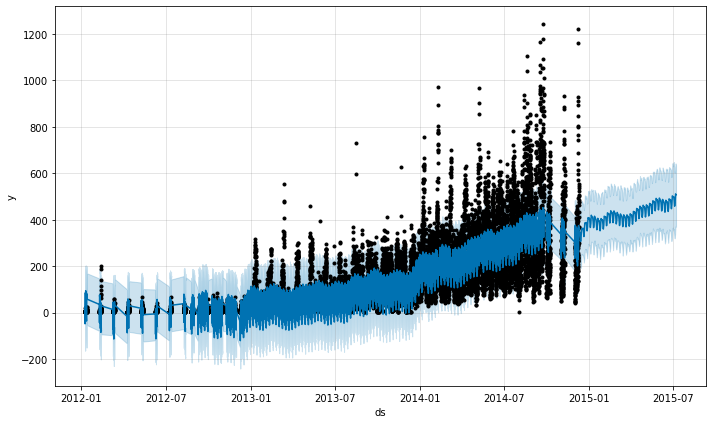

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


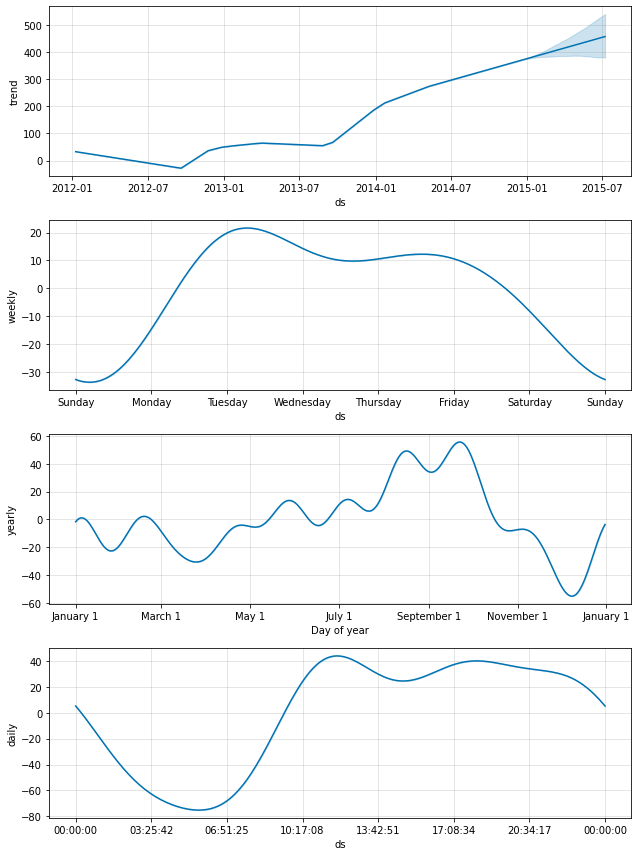

In [2]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# 使用Prophet预测jetrail未来7个月（210天）的count 从2012年8月25日开始到2014年9月25日结束
# 读入数据集
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/jettrail_train.csv',index_col=0)
# 修改列名 Datetime => ds, Count => y
df.rename(columns={'Datetime':'ds', 'Count':'y'}, inplace=True)
print(df.head())

# 拟合模型
model = Prophet()
model.fit(df)

# 构建待预测日期数据框，periods = 210 代表除历史数据的日期外再往后推210天即7个月
future = model.make_future_dataframe(periods=210)
#print(future.tail())

# 预测数据集
forecast = model.predict(future)
#print(forecast.columns)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 展示预测结果
model.plot(forecast)
plt.show()

# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
model.plot_components(forecast)
print(forecast.columns)



Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


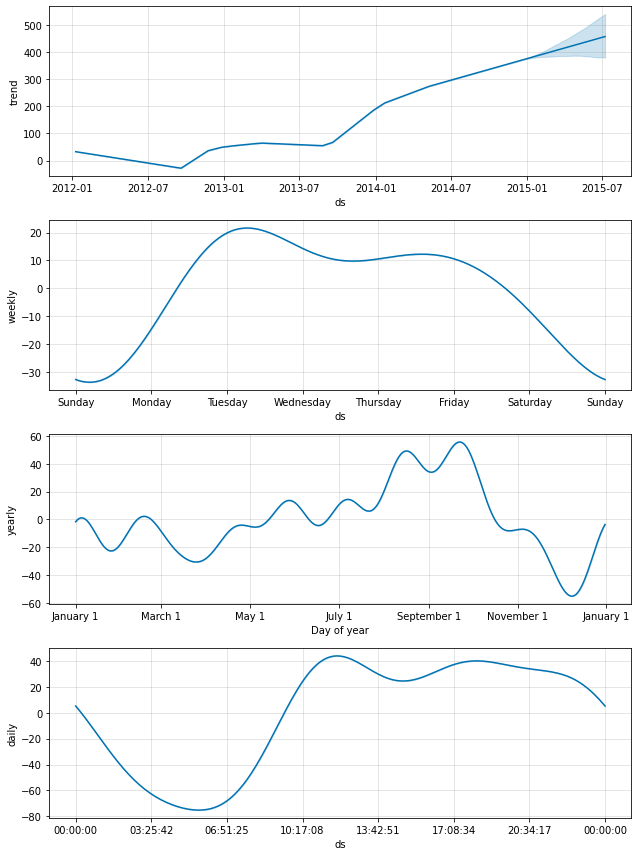

In [3]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
model.plot_components(forecast)
print(forecast.columns)

                       ds   cap
0     2012-01-09 00:00:00  1244
1     2012-01-09 01:00:00  1244
2     2012-01-09 02:00:00  1244
3     2012-01-09 03:00:00  1244
4     2012-01-09 04:00:00  1244
...                   ...   ...
18493 2015-07-03 23:00:00  1244
18494 2015-07-04 23:00:00  1244
18495 2015-07-05 23:00:00  1244
18496 2015-07-06 23:00:00  1244
18497 2015-07-07 23:00:00  1244

[18498 rows x 2 columns]


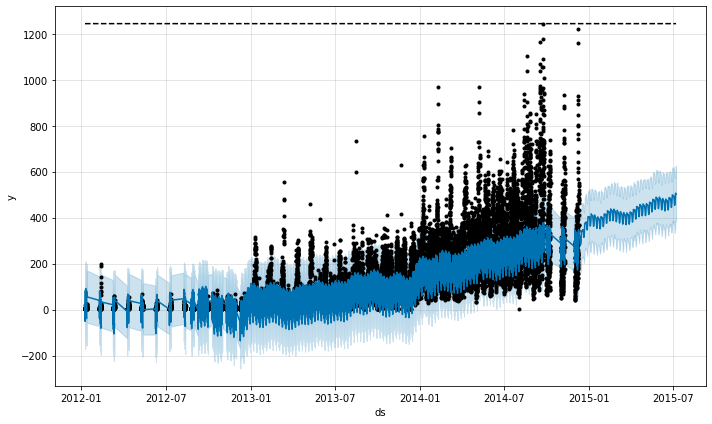

In [4]:
# 饱和增长
df['cap'] = 1500
m = Prophet(growth='logistic')
m.fit(df)

# 预测未来7个月的数据
future = m.make_future_dataframe(periods=210)
# 将未来的承载能力设定得和历史数据一样（历史最高值1244）
future['cap'] = 1244
fcst = m.predict(future)
fig = m.plot(fcst)
print(future)

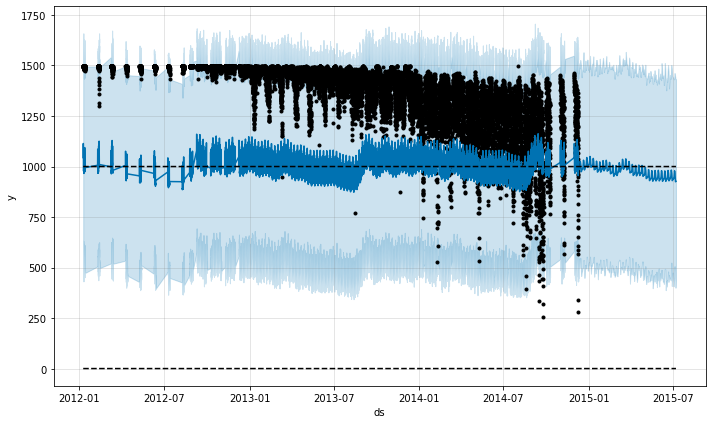

In [5]:
# 预测饱和减少
df['y'] = 1500 - df['y']
df['cap'] = 1000
# 设置下限
df['floor'] = 1.5
future['cap'] = 1000
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

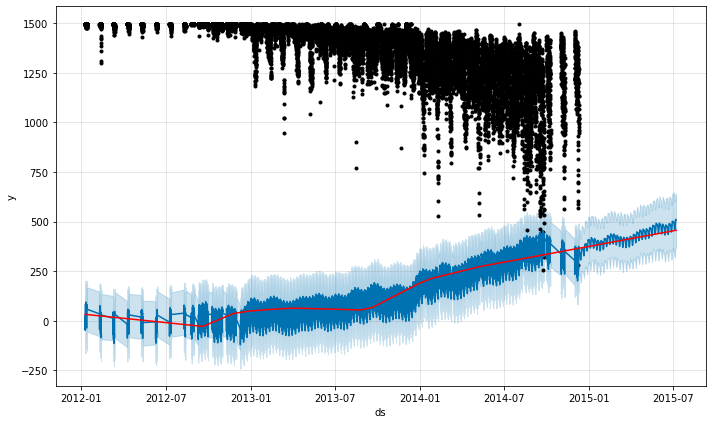

In [6]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
# plt.gca()获得当前的Axes对象ax
# 获取显著的突变点的位置
a = add_changepoints_to_plot(fig.gca(), m, forecast)
print(m)

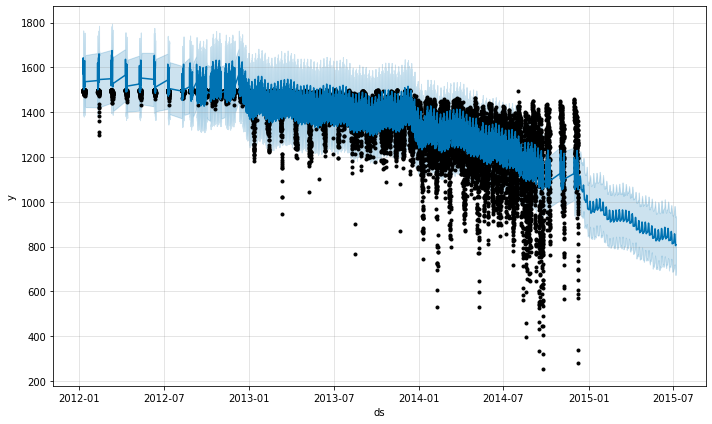

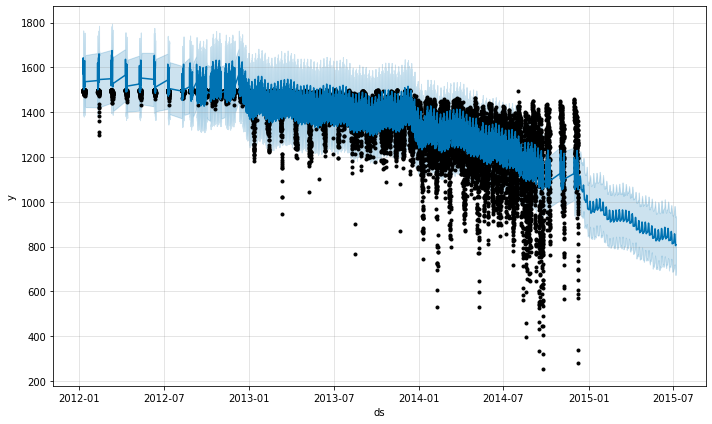

In [10]:
# 指定突变点的位置
m = Prophet(changepoints=['2014-04-10'])
m.fit(df)
future = m.make_future_dataframe(periods=210)
forecast = m.predict(future)
m.plot(forecast)

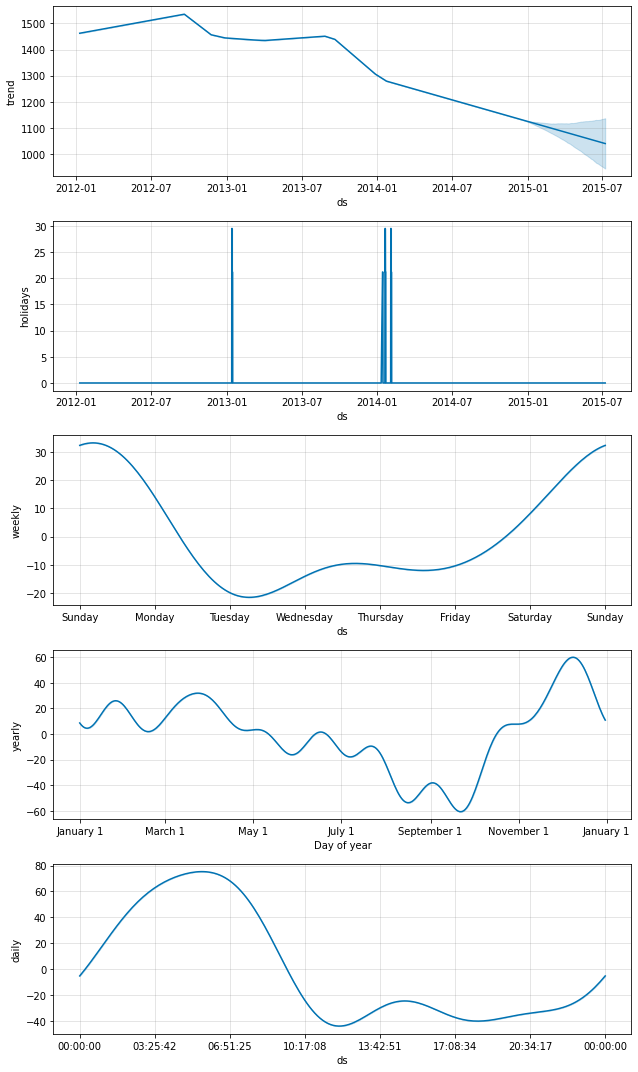

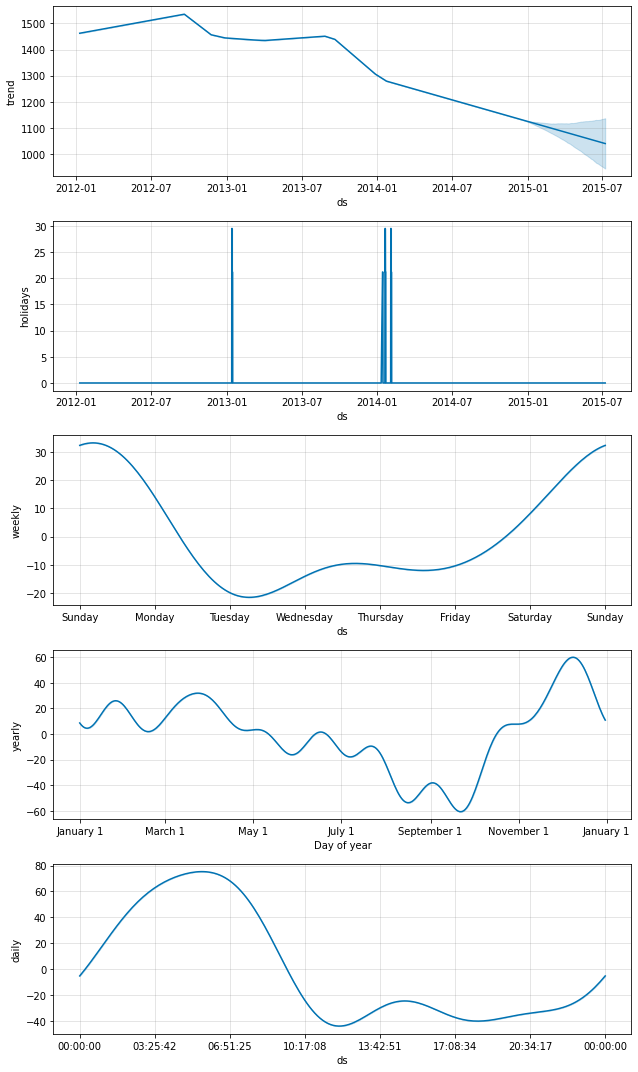

In [11]:
# 对节假日建模
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime([          '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02']),
  'lower_window': 0,
  'upper_window': 1,
})
#holidays = pd.concat((playoffs))
m = Prophet(holidays=playoffs)
m.fit(df)
future = m.make_future_dataframe(periods=210)
forecast = m.predict(future)
#print(forecast)
# 通过 forecast 数据框，展示节假日效应
forecast[(forecast['playoff']).abs() > 0][['ds', 'playoff']][-10:]
# 可以使用 plot_forecast_component（从fbprophet.plot导入）来画出独立的节假日的成分

from fbprophet.plot import plot_forecast_component
#m.plot_forecast_component(forecast, 'superbowl')
m.plot_components(forecast, 'playoff')